In [13]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as mc
import matplotlib.patches as mpatches
import shapely
from shapely import geos
import netCDF4
import os
import geopandas
import seaborn as sns
import PIL
import metpy.calc as mpcalc
from metpy.units import units
import matplotlib.cm as cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pyproj
import mpl_toolkits
from scipy.stats import circmean
import windrose
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

In [2]:
# Open and regrid ETOPO2V2 dataset
NOAA_ETOPO2V2_ds = xr.open_dataset('/home/563/ac9768/GBR/Aus_Bathymetry/ETOPO2v2c_f4.GQp62nWv.nc.part',engine="netcdf4")
NOAA_ETOPO2V2_ds_slice = NOAA_ETOPO2V2_ds.sel(x=slice(140,155),y=slice(-22,-11))
lon = np.linspace(min(NOAA_ETOPO2V2_ds_slice['x'].data), max(NOAA_ETOPO2V2_ds_slice['x'].data), len(NOAA_ETOPO2V2_ds_slice['x'].data))
lat = np.linspace(min(NOAA_ETOPO2V2_ds_slice['y'].data), max(NOAA_ETOPO2V2_ds_slice['y'].data), len(NOAA_ETOPO2V2_ds_slice['y'].data))
lon, lat = np.meshgrid(lon, lat)
topo = NOAA_ETOPO2V2_ds_slice['z'].data

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.12/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml


# Station data cleaning

In [ ]:
def JFMA_data(ds):
    var_jan_to_apr = [] 
    years = np.arange(1990,2021,1) # available years of station data
    for year in years:
        year_str = str(year)
        var_jfma = ds.sel(time=slice(year_str+'-01-01',year_str+'-04-30'))
        var_jan_to_apr.append(var_jfma)
    return xr.concat(var_jan_to_apr, dim='time').compute()


def wind_masks(ds_wdir,ds_wdspd):
    calm = ds_wdspd[ds_wdspd==0*units('m/s')]
    northerly = ds_wdir[ds_wdir==0*units('degrees')]
    calm_mask = xr.where(ds_wdspd==0*units('m/s'), np.nan, ds_wdspd)
    wdir_mask = xr.where(np.isnan(calm_mask), np.nan, ds_wdir)
    return wdir_mask,calm_mask


def calc_mean_wdir(ds):
    radian = np.deg2rad(ds)
    circmean_ds = circmean(radian,high=(2*np.pi),low=0,nan_policy='omit')
    wdir_mean = np.rad2deg(circmean_ds)
    return wdir_mean


def wind_times(ds,winds=None):
    morning = [20]
    four_am = ds.sel(time=ds.time.dt.hour.isin(morning)) #18 UTC = 4am AEST
    afternoon = [4]
    four_pm = ds.sel(time=ds.time.dt.hour.isin(afternoon)) #6 UTC = 4pm AEST
    return four_am, four_pm # when looking at specific hours: four_am[1]

In [ ]:
wdirT = JFMA_data(townsville_wdir)
wspdT = JFMA_data(townsville_wspd)
wdirC = JFMA_data(cairns_wdir)
wspdC = JFMA_data(cairns_wspd)

wdir_maskT,wspd_maskT = wind_masks(wdirT,wspdT)
wdir_maskC,wspd_maskC = wind_masks(wdirC,wspdC)

four_am_wdirT,four_pm_wdirT = wind_times(wdir_maskT)
four_am_wspdT,four_pm_wspdT = wind_times(wspd_maskT)
four_am_wdirC,four_pm_wdirC = wind_times(wdir_maskC)
four_am_wspdC,four_pm_wspdC = wind_times(wspd_maskC)

four_am_wdirT.dropna(dim='time')
four_am_wspdT.dropna(dim='time')
four_am_wdirC.dropna(dim='time')
four_am_wspdC.dropna(dim='time')

# Plot

In [7]:
import matplotlib as mpl
mpl.rcParams.update({
    'axes.titlesize': 20,        # Title font size
    'axes.labelsize': 15,        # Axis label font size
    'xtick.labelsize': 12,       # X-axis tick label font size
    'ytick.labelsize': 12,       # Y-axis tick label font size
    'legend.fontsize': 12,       # Legend font size
    'figure.titlesize': 20,      # Figure suptitle font size
})

In [3]:
barra_towns = xr.open_dataset("/g/data/q90/ac9768/GBR/barra-2/barra-2_850hPa-winds_towns.nc", engine="h5netcdf",chunks="auto").sel(time=slice('1979-01-01T00:00:00.000000000','2023-05-01T00:00:00.000000000'))
barra_cairns = xr.open_dataset("/g/data/q90/ac9768/GBR/barra-2/barra-2_850hPa-winds_cairns.nc", engine="h5netcdf",chunks="auto").sel(time=slice('1979-01-01T00:00:00.000000000','2023-05-01T00:00:00.000000000'))
barra_willis = xr.open_dataset("/g/data/q90/ac9768/GBR/barra-2/barra-2_850hPa-winds_willis.nc", engine="h5netcdf",chunks="auto").sel(time=slice('1979-01-01T00:00:00.000000000','2023-05-01T00:00:00.000000000'))

barra_sfc_towns = xr.open_dataset("/g/data/q90/ac9768/GBR/barra-2/barra-2_hourly-mean-sfc-winds_towns-radar-site.nc", engine="h5netcdf",chunks="auto").resample(time='1h').mean()
barra_sfc_cairns = xr.open_dataset("/g/data/q90/ac9768/GBR/barra-2/barra-2_hourly-mean-sfc-winds_cairns-radar-site.nc", engine="h5netcdf",chunks="auto").resample(time='1h').mean()
barra_sfc_willis = xr.open_dataset("/g/data/q90/ac9768/GBR/barra-2/barra-2_hourly-mean-sfc-winds_willis-radar-site.nc", engine="h5netcdf",chunks="auto").resample(time='1h').mean()


In [4]:
# for wind roses (plot (a))
def wind_times(barra_regime_ds: xr.Dataset):    
    winds = barra_regime_ds.wind_dir.compute()
    ne = winds[(winds>=0)&(winds<=90)].time.values
    se = winds[(winds>90)&(winds<=180)].time.values
    sw = winds[(winds>180)&(winds<=270)].time.values
    nw = winds[(winds>270)&(winds<=360)].time.values
    return ne,se,sw,nw
ne_towns,se_towns,sw_towns,nw_towns = wind_times(barra_towns)
ne_cairns,se_cairns,sw_cairns,nw_cairns = wind_times(barra_cairns)
ne_willis,se_willis,sw_willis,nw_willis = wind_times(barra_willis)

In [36]:
#for wind bar charts (b,c,d)
import string
def plot_regime_stats(all_values,ax,title,fig,label_start=0,legend: bool=False):
    """_summary_

    Args:
        all_values (_type_): _description_
        ax (_type_): _description_
        title (_type_): _description_
        legend (bool, optional): _description_. Defaults to False.
    """
    # Unpack the directional values
    categories = ["Jan", "Feb", "Mar", "Apr"]
    values1, values2, values3, values4 = zip(*all_values)

    # Plotting
    sns.set_theme(style="dark")
    ax.bar(categories, values1, label='NE', color='seagreen')
    ax.bar(categories, values2, bottom=values1, label='SE', color='royalblue')
    bottom2 = [i + j for i, j in zip(values1, values2)]
    ax.bar(categories, values3, bottom=bottom2, label='SW', color='purple')
    bottom3 = [i + j for i, j in zip(bottom2, values3)]
    ax.bar(categories, values4, bottom=bottom3, label='NW', color='darkorange')
    labels = list(string.ascii_lowercase)
    
    # Add text labels
    for i, (v1, v2, v3, v4) in enumerate(zip(values1, values2, values3, values4)):
        ax.text(i, v1 - v1 / 2 - 2, f'{v1:.1f}', ha='center', va='bottom', color="black", fontsize=12)
        ax.text(i, v1 + v2 / 2, f'{v2:.1f}', ha='center', va='bottom', color="black",fontsize=12)
        ax.text(i, v1 + v2 + v3 / 2 - 2, f'{v3:.1f}', ha='center', va='bottom', color="black",fontsize=12)
        ax.text(i, v1 + v2 + v3 + v4 / 2 - 2, f'{v4:.1f}', ha='center', va='bottom', color="black",fontsize=12)
    subplot_label = labels[label_start+1]
    ax.text(
        0.00, 1.02,
        f'({subplot_label})',
        transform=ax.transAxes,
        fontsize=18,
        va='bottom', ha='left'
    )
    ax.set_ylim(0, 100)
    ax.set_yticklabels([])
    ax.set_ylabel('Frequency (%)')
    ax.set_title(title, 
                 # pad=10,
                 fontsize=20)
    
    if legend:
        legend_elements = [
            # NE
            Patch(facecolor='green', alpha=1,
                  label='NE'),
            # SE
            Patch(facecolor='blue', alpha=1,
                  label='SE'),
            # SW
            Patch(facecolor='purple', alpha=1,
                  label='SW'),
            # NW
            Patch(facecolor='orange', alpha=1,
                  label='NW'),
        ]
        fig.legend(
            handles=legend_elements,
            loc='lower center',
            ncol=4,
            frameon=True,
            bbox_to_anchor=(0.78, 0.03)
        )
    return

def get_data(barra_ds):
    # Group wind directions by month
    ds = barra_ds
    months = ds["wind_dir"].groupby(ds["wind_dir"].time.dt.month)

    # Function to compute directional frequencies
    def wind_counts(winds):
        winds = winds.load()
        total = len(winds)
        bins = [(0, 90), (90, 180), (180, 270), (270, 360)]
        return [(winds[(winds > low ) & (winds <= high )].count() / total * 100)
                for low, high in bins]

    # Process selected months
    selected_months = [1, 2, 3, 4]  
    all_values = [wind_counts(months[m]) for m in selected_months]
    return all_values

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

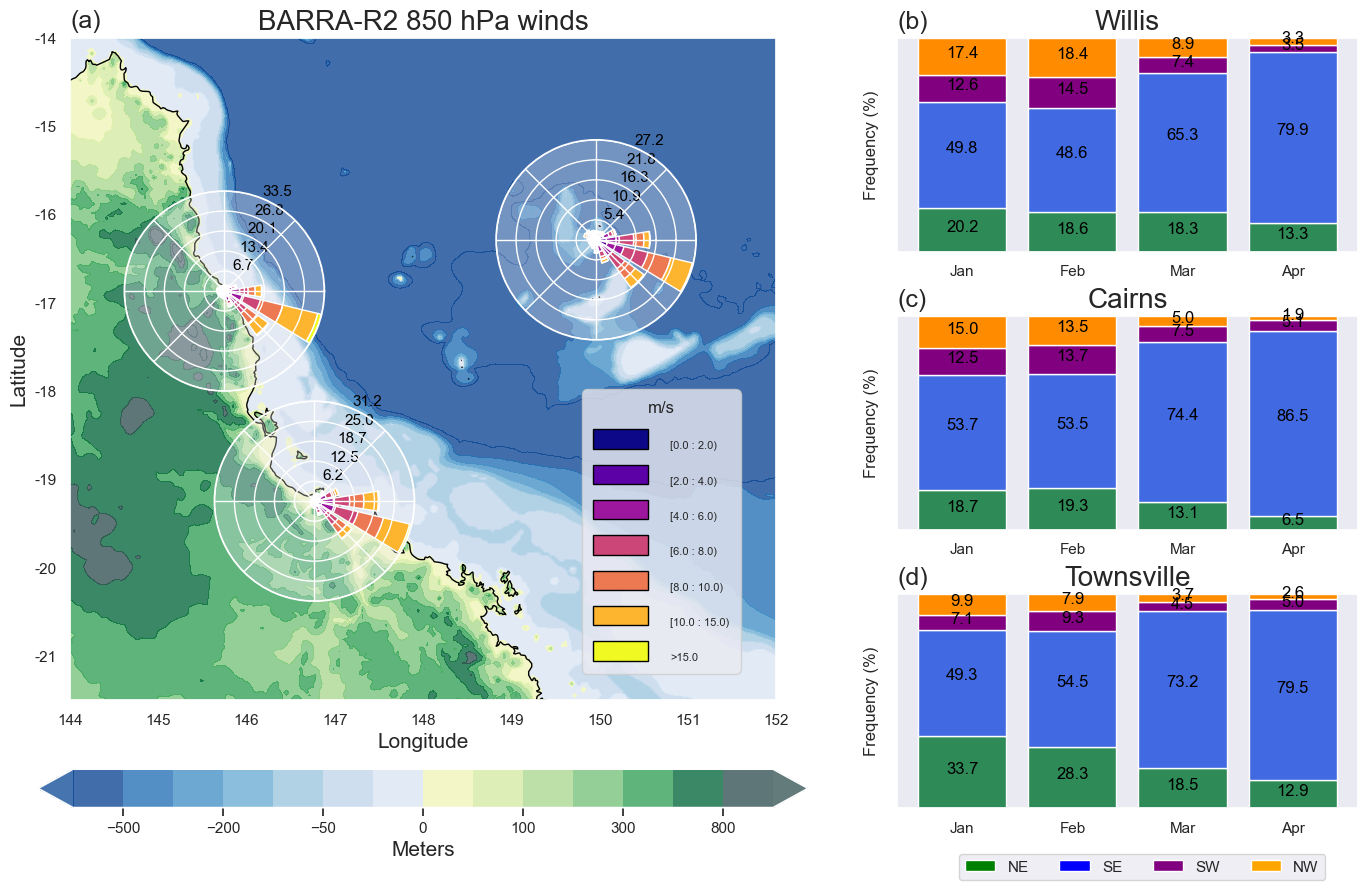

In [39]:
# all plots in one figure
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

fig = plt.figure(figsize=(18, 10))  # wider figure
gs = GridSpec(1, 2, width_ratios=[2, 1],wspace=0.02, figure=fig)  # left:map, right:3 subplots

# --- Left column: map ---
towns = barra_towns
cairns = barra_cairns
willis = barra_willis

proj = ccrs.PlateCarree()
main_ax = fig.add_subplot(gs[0, 0], projection=proj)
main_ax.set_extent([144, 152, -21.5, -14], crs=proj)
main_ax.coastlines()

color = ['#084594', '#2171b5', '#4292c6', '#6baed6', '#9ecae1', '#c6dbef', '#deebf7', '#f7fcb9','#d9f0a3','#addd8e',
         '#78c679','#31a354','#006837','darkslategrey','#d7ccca']
levels = [-800, -500, -300, -200, -100, -50, -25, 0, 50, 100, 200, 300, 500, 800, 1000]
cs = main_ax.contourf(lon,lat,topo,levels=levels,extend="both",colors=color,alpha=0.75)
cb = plt.colorbar(cs,fraction=0.05,location='bottom',orientation='horizontal',ax=main_ax,pad=0.09)
# cb = plt.colorbar(cs,aspect=20,ax=main_ax,pad=0.04)

# Coordinates of the station we were measuring windspeed
towns_lon, towns_lat = (146.77,-19.25)
cairns_lon, cairns_lat = (145.75,-16.87)
willis_lon, willis_lat = (149.96,-16.29)

size = 2
# Inset axes with a fixed size
wrax_towns = inset_axes(
    main_ax,
    width=size,  # size in inches
    height=size,  # size in inches
    loc="center",  # center bbox at given position
    bbox_to_anchor=(towns_lon, towns_lat),  # position of the axe
    bbox_transform=main_ax.transData,  # use data coordinate (not axe coordinate)
    axes_class=windrose.WindroseAxes,  # specify the class of the axe
)
wrax_cairns = inset_axes(
    main_ax,
    width=size,  # size in inches
    height=size,  # size in inches
    loc="center",  # center bbox at given position
    bbox_to_anchor=(cairns_lon, cairns_lat),  # position of the axe
    bbox_transform=main_ax.transData,  # use data coordinate (not axe coordinate)
    axes_class=windrose.WindroseAxes,  # specify the class of the axe
)
wrax_willis = inset_axes(
    main_ax,
    width=size,  # size in inches
    height=size,  # size in inches
    loc="center",  # center bbox at given position
    bbox_to_anchor=(willis_lon, willis_lat),  # position of the axe
    bbox_transform=main_ax.transData,  # use data coordinate (not axe coordinate)
    axes_class=windrose.WindroseAxes,  # specify the class of the axe
)

# set transparency of wind rose figure
wrax_cairns.patch.set_alpha(0.3)
wrax_towns.patch.set_alpha(0.3)
wrax_willis.patch.set_alpha(0.3)

# # create bar plots
barT = wrax_towns.bar(towns["wind_dir"], towns["wind_speed"],normed=True,bins=[0,2,4,6,8,10,15],cmap=cm.plasma)
barC = wrax_cairns.bar(cairns["wind_dir"], cairns["wind_speed"],normed=True,bins=[0,2,4,6,8,10,15],cmap=cm.plasma)
barW = wrax_willis.bar(willis["wind_dir"], willis["wind_speed"],normed=True,bins=[0,2,4,6,8,10,15],cmap=cm.plasma)
wrax_cairns.set_legend(
    title="m/s",
    bbox_to_anchor=(2.3, -1.4),fontsize=20) #(2.2,-1.2)) # #bbox_to_anchor=(4, 0.65, 1, 1)) #

for ax in [wrax_towns, wrax_cairns,wrax_willis]:
    ax.tick_params(colors='black',labelbottom=False)#labelleft=False

# other plot details
cb.set_label("Meters",fontsize=15)
main_ax.set_title("BARRA-R2 850 hPa winds",fontsize=20,)#y=1.05)
# main_ax.set_title("BARRA-R2 surface winds 14 AEST",fontsize=18)
main_ax.set_xticks([144,145,146,147,148,149,150,151,152])
main_ax.set_xticklabels([144,145,146,147,148,149,150,151,152])
main_ax.set_yticks([-21,-20,-19,-18,-17,-16,-15,-14])
main_ax.set_yticklabels([-21,-20,-19,-18,-17,-16,-15,-14])
main_ax.set_xlabel("Longitude",fontsize=15)
main_ax.set_ylabel("Latitude",fontsize=15)
fig.text(
    0.185, 0.89,  # above bottom block
    "(a)",
    fontsize=18,
)

# --- Right column: 3 vertical subplots ---
# Create a nested GridSpec inside the right column
gs_right = GridSpecFromSubplotSpec(3, 1, subplot_spec=gs[0, 1], hspace=0.3)

ax_col = [fig.add_subplot(gs_right[i]) for i in range(3)]

# Now plot your regime stats
towns = get_data(barra_towns)
cairns = get_data(barra_cairns)
willis = get_data(barra_willis)

plot_regime_stats(willis, ax_col[0], "Willis", fig, label_start=0)
plot_regime_stats(cairns, ax_col[1], "Cairns", fig, label_start=1)
plot_regime_stats(towns, ax_col[2], "Townsville", fig, label_start=2,legend=True)

plt.tight_layout()
plt.show()
fig.savefig('/home/563/ac9768/GBR/scripts/Paper_figures/f03.png', bbox_inches='tight', dpi=300)

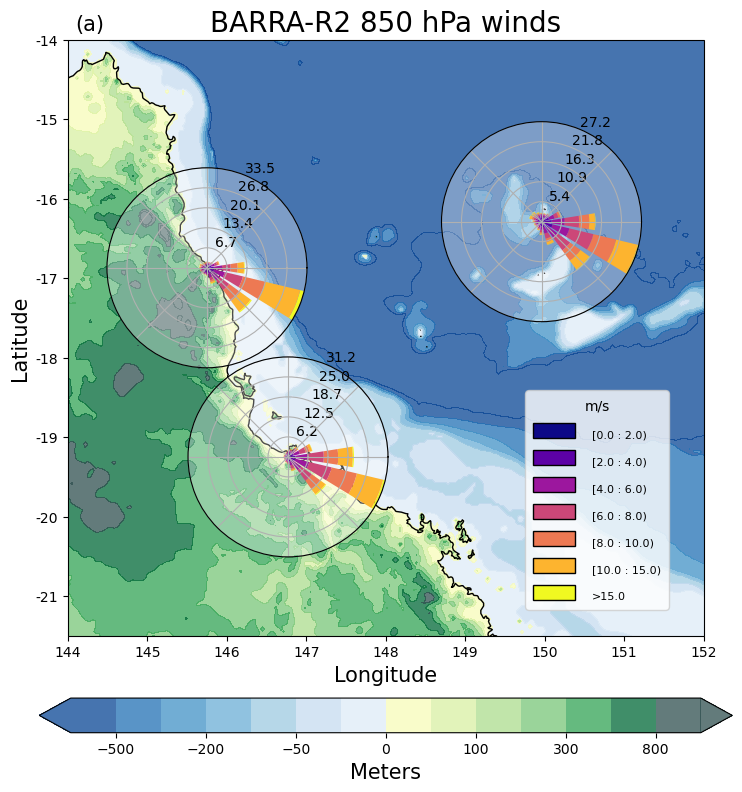

In [32]:
towns = barra_towns
cairns = barra_cairns
willis = barra_willis

# plot regimes
# towns = towns_sfc_under_sw
# cairns = cairns_sfc_under_sw
# willis = willis_sfc_under_sw

# plot 2pm --4; 6am --20
# towns = towns.sel(time=towns.time.dt.hour.isin(4))
# cairns = cairns.sel(time=cairns.time.dt.hour.isin(4))
# willis = willis.sel(time=willis.time.dt.hour.isin(4))

proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 9))
main_ax = fig.add_subplot(1, 1, 1, projection=proj)
minlon, maxlon, minlat, maxlat = (144, 152, -21.5, -14)
main_ax.set_extent([minlon, maxlon, minlat, maxlat], crs=proj)
main_ax.coastlines()

color = ['#084594', '#2171b5', '#4292c6', '#6baed6', '#9ecae1', '#c6dbef', '#deebf7', '#f7fcb9','#d9f0a3','#addd8e',
         '#78c679','#31a354','#006837','darkslategrey','#d7ccca']
levels = [-800, -500, -300, -200, -100, -50, -25, 0, 50, 100, 200, 300, 500, 800, 1000]
cs = main_ax.contourf(lon,lat,topo,levels=levels,extend="both",colors=color,alpha=0.75)
cb = plt.colorbar(cs,fraction=0.05,location='bottom',orientation='horizontal',ax=main_ax,pad=0.09)
# cb = plt.colorbar(cs,aspect=20,ax=main_ax,pad=0.04)

# Coordinates of the station we were measuring windspeed
towns_lon, towns_lat = (146.77,-19.25)
cairns_lon, cairns_lat = (145.75,-16.87)
willis_lon, willis_lat = (149.96,-16.29)

size = 2
# Inset axes with a fixed size
wrax_towns = inset_axes(
    main_ax,
    width=size,  # size in inches
    height=size,  # size in inches
    loc="center",  # center bbox at given position
    bbox_to_anchor=(towns_lon, towns_lat),  # position of the axe
    bbox_transform=main_ax.transData,  # use data coordinate (not axe coordinate)
    axes_class=windrose.WindroseAxes,  # specify the class of the axe
)
wrax_cairns = inset_axes(
    main_ax,
    width=size,  # size in inches
    height=size,  # size in inches
    loc="center",  # center bbox at given position
    bbox_to_anchor=(cairns_lon, cairns_lat),  # position of the axe
    bbox_transform=main_ax.transData,  # use data coordinate (not axe coordinate)
    axes_class=windrose.WindroseAxes,  # specify the class of the axe
)
wrax_willis = inset_axes(
    main_ax,
    width=size,  # size in inches
    height=size,  # size in inches
    loc="center",  # center bbox at given position
    bbox_to_anchor=(willis_lon, willis_lat),  # position of the axe
    bbox_transform=main_ax.transData,  # use data coordinate (not axe coordinate)
    axes_class=windrose.WindroseAxes,  # specify the class of the axe
)

# set transparency of wind rose figure
wrax_cairns.patch.set_alpha(0.3)
wrax_towns.patch.set_alpha(0.3)
wrax_willis.patch.set_alpha(0.3)

# # create bar plots
barT = wrax_towns.bar(towns["wind_dir"], towns["wind_speed"],normed=True,bins=[0,2,4,6,8,10,15],cmap=cm.plasma)
barC = wrax_cairns.bar(cairns["wind_dir"], cairns["wind_speed"],normed=True,bins=[0,2,4,6,8,10,15],cmap=cm.plasma)
barW = wrax_willis.bar(willis["wind_dir"], willis["wind_speed"],normed=True,bins=[0,2,4,6,8,10,15],cmap=cm.plasma)
wrax_cairns.set_legend(
    title="m/s",
    bbox_to_anchor=(2.1, -1.2),fontsize=15) #(2.2,-1.2)) # #bbox_to_anchor=(4, 0.65, 1, 1)) #

for ax in [wrax_towns, wrax_cairns,wrax_willis]:
    ax.tick_params(colors='black',labelbottom=False)#labelleft=False

# other plot details
cb.set_label("Meters",fontsize=15)
main_ax.set_title("BARRA-R2 850 hPa winds",fontsize=20,)#y=1.05)
# main_ax.set_title("BARRA-R2 surface winds 14 AEST",fontsize=18)
main_ax.set_xticks([144,145,146,147,148,149,150,151,152])
main_ax.set_xticklabels([144,145,146,147,148,149,150,151,152])
main_ax.set_yticks([-21,-20,-19,-18,-17,-16,-15,-14])
main_ax.set_yticklabels([-21,-20,-19,-18,-17,-16,-15,-14])
main_ax.set_xlabel("Longitude",fontsize=15)
main_ax.set_ylabel("Latitude",fontsize=15)
fig.text(
    0.34, 0.89,  # above bottom block
    "(a)",
    fontsize=15,
)
fig.savefig('/home/563/ac9768/GBR/scripts/Paper_figures/f03.png', bbox_inches='tight', dpi=300)
plt.show()

In [18]:
def surface_winds_under_regimes(barra_sfc_ds,ne_times,se_times,sw_times,nw_times):
    # barra 850 hPa and barra surface winds have same time dimension length
    ne = barra_sfc_ds.sel(time=ne_times)
    se = barra_sfc_ds.sel(time=se_times)
    sw = barra_sfc_ds.sel(time=sw_times)
    nw = barra_sfc_ds.sel(time=nw_times)
    return ne,se,sw,nw

barra_sfc_towns = xr.open_dataset("/g/data/q90/ac9768/GBR/barra-2/barra-2_hourly-mean-sfc-winds_towns-radar-site.nc", engine="h5netcdf",chunks="auto").resample(time='1h').mean()
barra_sfc_cairns = xr.open_dataset("/g/data/q90/ac9768/GBR/barra-2/barra-2_hourly-mean-sfc-winds_cairns-radar-site.nc", engine="h5netcdf",chunks="auto").resample(time='1h').mean()
barra_sfc_willis = xr.open_dataset("/g/data/q90/ac9768/GBR/barra-2/barra-2_hourly-mean-sfc-winds_willis-radar-site.nc", engine="h5netcdf",chunks="auto").resample(time='1h').mean()

towns_sfc_under_ne,towns_sfc_under_se,towns_sfc_under_sw,towns_sfc_under_nw = surface_winds_under_regimes(barra_sfc_towns,ne_towns,se_towns,sw_towns,nw_towns)
cairns_sfc_under_ne,cairns_sfc_under_se,cairns_sfc_under_sw,cairns_sfc_under_nw = surface_winds_under_regimes(barra_sfc_cairns,ne_cairns,se_cairns,sw_cairns,nw_cairns)
willis_sfc_under_ne,willis_sfc_under_se,willis_sfc_under_sw,willis_sfc_under_nw = surface_winds_under_regimes(barra_sfc_willis,ne_willis,se_willis,sw_willis,nw_willis)

KeyError: "not all values found in index 'time'"